# **PART 1: Model Training & Comparison**

**Objective:**  
Train multiple ML/DL models on the **MIMII pump dataset** to detect industrial anomalies from sound.

**Models to Compare:**  
| Type | Model |
|------|-------|
| Traditional ML | KNN, Isolation Forest, SVM |
| Deep Learning | CNN, VGG-like CNN, **ResNet-like CNN** |

**Goal:**  
- Extract MFCC features  
- Train all models  
- Compare using **F1-score, AUC-ROC, PR-AUC**  
- **Select best model** → proceed to transfer learning

**Why MIMII?**  
- Publically available, labeled, industrial sound dataset  
- Ideal for baseline training before tractor adaptation



 # **Imports and Setup**


In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from pathlib import Path
from tqdm import tqdm

# Audio processing
import librosa
import librosa.display
import soundfile as sf

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)
from sklearn.utils import resample

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout, Flatten,
    BatchNormalization, Add, ReLU, GlobalAveragePooling2D, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Model persistence
import joblib
import json

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# **Configuration and Data Paths**

Setting up flexible configuration that works across different environments:
- Google Colab
- Local development
- Production deployment

In [ ]:
class Config:
    """Central configuration for the project."""

    def __init__(self, environment='colab', config_dict=None):
        if config_dict:
            # Load from dictionary
            for key, value in config_dict.items():
                setattr(self, key, value)
            # Ensure required attributes exist, set defaults if necessary
            self.environment = config_dict.get('environment', environment)
            self.sample_rate = config_dict.get('sample_rate', 16000)
            self.duration = config_dict.get('duration', 10)
            self.n_mfcc = config_dict.get('n_mfcc', 40)
            self.max_len = config_dict.get('max_len', 100)
            self.apply_highpass = config_dict.get('apply_highpass', False) # Default
            self.test_size = config_dict.get('test_size', 0.2) # Default
            self.epochs = config_dict.get('epochs', 20) # Default
            self.batch_size = config_dict.get('batch_size', 32) # Default
            self.random_state = config_dict.get('random_state', 42) # Default
            self.machine_ids = config_dict.get('machine_ids', ["id_00", "id_02", "id_04", "id_06"]) # Default
            self.output_dir = Path(config_dict.get('output_dir', './outputs')) # Default
            self.base_path = Path(config_dict.get('base_path', './data/pump')) # Default
            self.validation_split = config_dict.get('validation_split', 0.2) # Default
            self.early_stopping_patience = config_dict.get('early_stopping_patience', 5) # Default
            self.knn_params = config_dict.get('knn_params', {'n_neighbors': 5, 'weights': 'distance'}) # Default
            self.svm_params = config_dict.get('svm_params', {'kernel': 'rbf', 'probability': True, 'C': 1.0}) # Default
            self.iso_forest_params = config_dict.get('iso_forest_params', {'contamination': 0.1, 'random_state': 42}) # Default

        else:
            # Initialize with defaults (like the original Config class)
            self.environment = environment
            self.setup_paths()
            self.setup_parameters()

    def setup_paths(self):
        """Configure paths based on environment."""
        if self.environment == 'colab':
            from google.colab import drive
            drive.mount('/content/drive')
            self.base_path = Path("/content/drive/My Drive/TractorCare/data/pump/")
            self.output_dir = Path("/content/drive/My Drive/TractorCare/outputs/")
        elif self.environment == 'local':
            self.base_path = Path("./data/pump/")
            self.output_dir = Path("./outputs/")
        else:  # production
            self.base_path = Path("/app/data/pump/")
            self.output_dir = Path("/app/outputs/")

        # Create output directory if it doesn't exist
        self.output_dir.mkdir(parents=True, exist_ok=True)

        self.machine_ids = ["id_00", "id_02", "id_04", "id_06"]

    def setup_parameters(self):
        """Set feature extraction and training parameters."""
        # Audio parameters
        self.sample_rate = 16000
        self.duration = 10

        # Feature extraction
        self.n_mfcc = 40
        self.max_len = 100
        self.apply_highpass = False

        # Training parameters
        self.test_size = 0.2
        self.validation_split = 0.2
        self.random_state = 42

        # Model training
        self.epochs = 20
        self.batch_size = 32
        self.early_stopping_patience = 5

        # Traditional ML models
        self.knn_params = {'n_neighbors': 5, 'weights': 'distance'}
        self.svm_params = {'kernel': 'rbf', 'probability': True, 'C': 1.0}
        self.iso_forest_params = {'contamination': 0.1, 'random_state': 42}

    def get_file_paths(self):
        """Load all audio file paths from dataset."""
        normal_files = []
        abnormal_files = []

        for mid in self.machine_ids:
            normal_dir = self.base_path / mid / "normal"
            abnormal_dir = self.base_path / mid / "abnormal"

            if normal_dir.exists():
                normal_files.extend([str(f) for f in normal_dir.glob("*.wav")])
            else:
                print(f"⚠ Warning: {normal_dir} not found")

            if abnormal_dir.exists():
                abnormal_files.extend([str(f) for f in abnormal_dir.glob("*.wav")])
            else:
                print(f"⚠ Warning: {abnormal_dir} not found")

        return normal_files, abnormal_files

    def save_config(self):
        """Save configuration to JSON file."""
        config_dict = {
            'environment': self.environment,
            'sample_rate': self.sample_rate,
            'duration': self.duration,
            'n_mfcc': self.n_mfcc,
            'max_len': self.max_len,
            'test_size': self.test_size,
            'epochs': self.epochs,
            'batch_size': self.batch_size
        }

        config_path = self.output_dir / 'config.json'
        with open(config_path, 'w') as f:
            json.dump(config_dict, f, indent=4)

        print(f"✓ Configuration saved to {config_path}")

# Initialize configuration (change 'colab' to 'local' if running locally)
config = Config(environment='colab')

# Load file paths
normal_files, abnormal_files = config.get_file_paths()

print(f"\n{'='*60}")
print(f"Dataset Summary:")
print(f"{'='*60}")
print(f"Normal samples: {len(normal_files)}")
print(f"Abnormal samples: {len(abnormal_files)}")
print(f"Total samples: {len(normal_files) + len(abnormal_files)}")
print(f"Class imbalance ratio: {len(normal_files)/len(abnormal_files):.2f}:1")
print(f"{'='*60}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Dataset Summary:
Normal samples: 2845
Abnormal samples: 456
Total samples: 3301
Class imbalance ratio: 6.24:1


# **Feature Extraction Functions**

MFCC (Mel-Frequency Cepstral Coefficients) extraction with:
- Optional high-pass filtering for noise reduction
- Automatic padding/truncation to fixed length
- Robust error handling

In [ ]:
def extract_mfcc_features(file_path, config):
    """
    Extract MFCC features from audio file with optional preprocessing.

    Parameters:
    -----------
    file_path : str
        Path to the audio file
    config : Config
        Configuration object with parameters

    Returns:
    --------
    mfcc : np.ndarray
        MFCC features of shape (n_mfcc, max_len) or None if processing fails
    """
    try:
        # Load audio
        audio, sr = librosa.load(
            file_path,
            sr=config.sample_rate,
            duration=config.duration
        )

        # Optional high-pass filter to reduce low-frequency noise
        if config.apply_highpass:
            from scipy.signal import butter, filtfilt
            nyquist = sr / 2
            cutoff = 100  # Hz
            b, a = butter(4, cutoff / nyquist, btype='high')
            audio = filtfilt(b, a, audio)

        # Extract MFCCs
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=sr,
            n_mfcc=config.n_mfcc
        )

        # Pad or truncate to fixed length
        if mfcc.shape[1] < config.max_len:
            pad_width = config.max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :config.max_len]

        return mfcc

    except Exception as e:
        print(f"✗ Error processing {file_path}: {str(e)}")
        return None


def compute_statistics(mfcc):
    """
    Compute statistical features from MFCC for traditional ML models.

    Features computed:
    - Mean, Standard Deviation, Max, Min, Median of MFCCs
    - Delta (1st derivative) mean and std
    - Delta-Delta (2nd derivative) mean and std

    Parameters:
    -----------
    mfcc : np.ndarray
        MFCC features of shape (n_mfcc, time_steps)

    Returns:
    --------
    stats : np.ndarray
        Flattened array of statistical features
    """
    # Basic statistics
    mean = np.mean(mfcc, axis=1)
    std = np.std(mfcc, axis=1)
    maximum = np.max(mfcc, axis=1)
    minimum = np.min(mfcc, axis=1)
    median = np.median(mfcc, axis=1)

    # Delta features (velocity)
    delta = librosa.feature.delta(mfcc)
    delta_mean = np.mean(delta, axis=1)
    delta_std = np.std(delta, axis=1)

    # Delta-Delta features (acceleration)
    delta2 = librosa.feature.delta(mfcc, order=2)
    delta2_mean = np.mean(delta2, axis=1)
    delta2_std = np.std(delta2, axis=1)

    # Concatenate all features
    stats = np.concatenate([
        mean, std, maximum, minimum, median,
        delta_mean, delta_std, delta2_mean, delta2_std
    ])

    return stats


def extract_features_batch(file_paths, labels, config, desc="Extracting features"):
    """
    Extract features from multiple audio files with progress bar.

    Parameters:
    -----------
    file_paths : list
        List of audio file paths
    labels : list
        List of labels (0=normal, 1=abnormal)
    config : Config
        Configuration object
    desc : str
        Description for progress bar

    Returns:
    --------
    X_mfcc : np.ndarray
        Array of MFCC features for CNN models
    X_stats : np.ndarray
        Array of statistical features for traditional ML
    y : np.ndarray
        Array of labels
    valid_files : list
        List of successfully processed file paths
    """
    X_mfcc = []
    X_stats = []
    y = []
    valid_files = []
    failed_count = 0

    for file_path, label in tqdm(zip(file_paths, labels),
                                  total=len(file_paths),
                                  desc=desc):
        mfcc = extract_mfcc_features(file_path, config)

        if mfcc is not None:
            X_mfcc.append(mfcc)
            X_stats.append(compute_statistics(mfcc))
            y.append(label)
            valid_files.append(file_path)
        else:
            failed_count += 1

    print(f"\n Successfully processed: {len(valid_files)} files")
    if failed_count > 0:
        print(f"✗ Failed to process: {failed_count} files")

    return (np.array(X_mfcc), np.array(X_stats),
            np.array(y), valid_files)

print(" Feature extraction functions defined")

 Feature extraction functions defined


In [ ]:
def augment_audio(audio, sr):
    augments = []
    noise = np.random.normal(0, 0.005, audio.shape)
    augments.append(audio + noise)
    try:
        augments.append(librosa.effects.time_stretch(audio, rate=1.1))
        augments.append(librosa.effects.time_stretch(audio, rate=0.9))
    except Exception:
        pass
    try:
        augments.append(librosa.effects.pitch_shift(audio, sr, n_steps=2))
        augments.append(librosa.effects.pitch_shift(audio, sr, n_steps=-2))
    except Exception:
        pass
    return augments

def extract_mfcc_features_from_audio(audio, sr, config):
    try:
        if len(audio) > config.sample_rate * config.duration:
            audio = audio[:config.sample_rate * config.duration]
        else:
            audio = np.pad(audio, (0, max(0, config.sample_rate*config.duration - len(audio))), mode='constant')
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=sr,
            n_mfcc=config.n_mfcc
        )
        max_len = config.max_len
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
        return mfcc
    except Exception as e:
        print(f"[Augment] MFCC extraction error: {str(e)}")
        return None



# **Load and Balance Dataset**

Handling class imbalance by undersampling the majority class (normal) to match the minority class (abnormal).

In [ ]:
 # Balance the dataset using undersampling
print("Balancing dataset...")
normal_sample_size = len(abnormal_files)
normal_files_balanced = resample(
    normal_files,
    n_samples=normal_sample_size,
    random_state=config.random_state
)

print(f"\n{'='*60}")
print("Balanced Dataset:")
print(f"{'='*60}")
print(f"Normal samples: {len(normal_files_balanced)}")
print(f"Abnormal samples: {len(abnormal_files)}")
print(f"Total balanced samples: {len(normal_files_balanced) + len(abnormal_files)}")
print(f"{'='*60}\n")

# Combine file paths and create labels
all_files = normal_files_balanced + abnormal_files
all_labels = [0] * len(normal_files_balanced) + [1] * len(abnormal_files)

# Extract features from all files
X_mfcc, X_stats, y, valid_files = extract_features_batch(
    all_files,
    all_labels,
    config,
    desc="Extracting features from balanced dataset"
)

print(f"\n{'='*60}")
print("Feature Extraction Complete:")
print(f"{'='*60}")
print(f"MFCC features shape: {X_mfcc.shape}")
print(f"Statistical features shape: {X_stats.shape}")
print(f"Labels shape: {y.shape}")
print(f"{'='*60}")

Balancing dataset...

Balanced Dataset:
Normal samples: 456
Abnormal samples: 456
Total balanced samples: 912



Extracting features from balanced dataset: 100%|██████████| 912/912 [00:53<00:00, 16.89it/s]


 Successfully processed: 912 files

Feature Extraction Complete:
MFCC features shape: (912, 40, 100)
Statistical features shape: (912, 360)
Labels shape: (912,)


# **Visualize Sample Features**

Compare MFCC features between normal and abnormal samples to understand the differences.

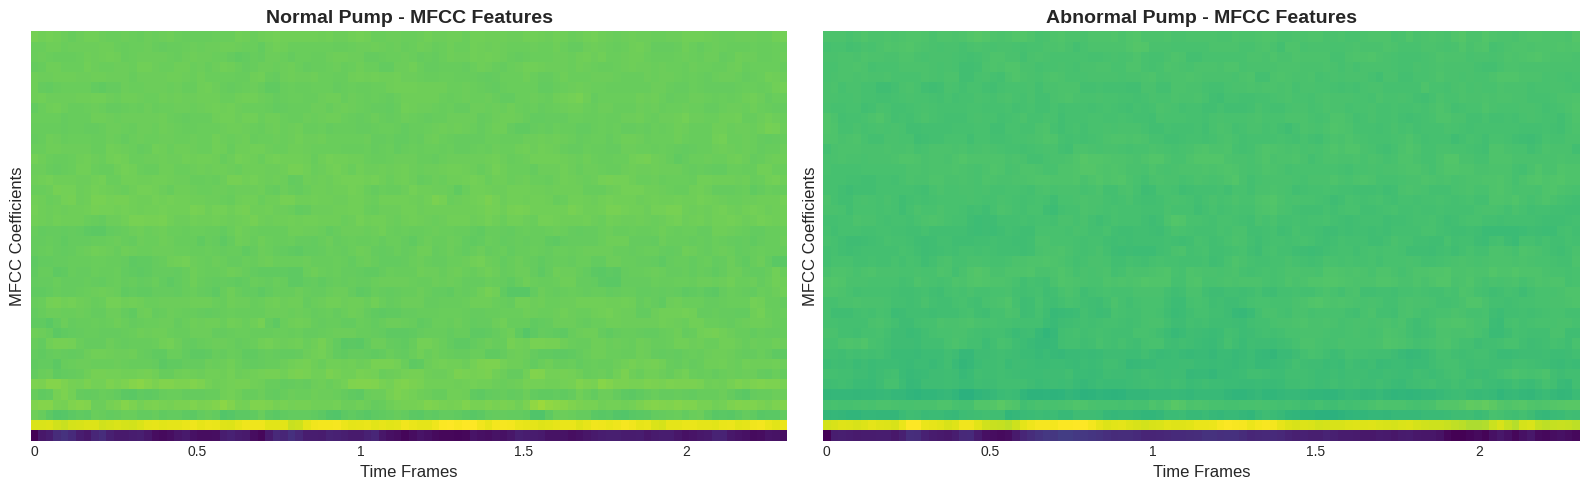

 Visualization saved to /content/drive/My Drive/TractorCare/outputs/mfcc_comparison.png


In [ ]:
# Get sample indices
normal_idx = np.where(y == 0)[0][0]
abnormal_idx = np.where(y == 1)[0][0]

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Normal sample
librosa.display.specshow(X_mfcc[normal_idx], x_axis='time', ax=axes[0], cmap='viridis')
axes[0].set_title('Normal Pump - MFCC Features', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MFCC Coefficients', fontsize=12)
axes[0].set_xlabel('Time Frames', fontsize=12)

# Abnormal sample
librosa.display.specshow(X_mfcc[abnormal_idx], x_axis='time', ax=axes[1], cmap='viridis')
axes[1].set_title('Abnormal Pump - MFCC Features', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MFCC Coefficients', fontsize=12)
axes[1].set_xlabel('Time Frames', fontsize=12)

plt.tight_layout()
plt.savefig(config.output_dir / 'mfcc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Visualization saved to {config.output_dir / 'mfcc_comparison.png'}")

# **Prepare Data for Training**

Split data into training and testing sets for both traditional ML and deep learning models.

#Traditional ML Models
Split data for traditional models (using statistical features)

In [ ]:

X_train_stats, X_test_stats, y_train_trad, y_test_trad = train_test_split(
    X_stats, y,
    test_size=config.test_size,
    random_state=config.random_state,
    stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_stats_scaled = scaler.fit_transform(X_train_stats)
X_test_stats_scaled = scaler.transform(X_test_stats)


print("Traditional ML Data:")
print(f"{'='*60}")
print(f"Training set: {X_train_stats_scaled.shape}")
print(f"Test set: {X_test_stats_scaled.shape}")



Traditional ML Data:
Training set: (729, 360)
Test set: (183, 360)


# Deep Learning Models
Split data for CNN models (using raw MFCC features)

In [ ]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_mfcc, y,
    test_size=config.test_size,
    random_state=config.random_state,
    stratify=y
)

# Reshape for CNN input (add channel dimension)
X_train_cnn = X_train_cnn[..., np.newaxis]
X_test_cnn = X_test_cnn[..., np.newaxis]

print("Deep Learning Data:")
print(f"{'='*60}")
print(f"Training set: {X_train_cnn.shape}")
print(f"Test set: {X_test_cnn.shape}")
print(f"Input shape for CNN: {X_train_cnn.shape[1:]}")


Deep Learning Data:
Training set: (729, 40, 100, 1)
Test set: (183, 40, 100, 1)
Input shape for CNN: (40, 100, 1)


# **Model Architectures**

Define functions to build different CNN architectures:
1. **Simple CNN** - Basic architecture for baseline
2. **VGG-like CNN** - Deeper network with repeated conv blocks
3. **ResNet-like CNN** - Network with skip connections for better gradient flow

In [ ]:
def build_simple_cnn(input_shape):
    """
    Build a simple CNN architecture.

    Architecture:
    - 2 Conv blocks (32, 64 filters)
    - MaxPooling after each conv block
    - Fully connected layers with dropout
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def build_vgg_cnn(input_shape):
    """
    Build VGG-like CNN architecture.

    Architecture:
    - 3 VGG blocks (32, 64, 128 filters)
    - Each block has 2 conv layers
    - MaxPooling after each block
    """
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Classifier
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def resnet_block(x, filters, kernel_size=3, stride=1):
    """
    Residual block for ResNet-like architecture.

    Implements skip connection to allow gradient flow.
    """
    # Main path
    y = Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    y = BatchNormalization()(y)
    y = Conv2D(filters, kernel_size, strides=1, padding='same')(y)
    y = BatchNormalization()(y)

    # Skip connection
    if stride != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, 1, strides=stride, padding='same')(x)
        x = BatchNormalization()(x)

    # Merge paths
    out = Add()([x, y])
    out = ReLU()(out)

    return out


def build_resnet_cnn(input_shape):
    """
    Build ResNet-like CNN architecture.

    Architecture:
    - Initial conv layer
    - 4 residual blocks
    - Global average pooling
    - Fully connected layers
    """
    inputs = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(32, 7, strides=2, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual blocks
    x = resnet_block(x, 32)
    x = resnet_block(x, 32)
    x = resnet_block(x, 64, stride=2)
    x = resnet_block(x, 64)

    # Classifier
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print(" CNN model architectures defined")

 CNN model architectures defined


# **Training Pipeline**

Complete training pipeline with:
- Progress tracking
- Model evaluation
- Results storage

In [ ]:
def compute_metrics(y_true, y_pred, y_pred_proba=None):
    """Compute comprehensive evaluation metrics."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred).tolist()
    }

    # Add ROC-AUC if probabilities are provided
    if y_pred_proba is not None:
        try:
            metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
        except:
            metrics['roc_auc'] = None

    return metrics


def train_traditional_models(X_train, X_test, y_train, y_test, config):
    """Train all traditional ML models."""
    results = {}

    print(f"\n{'='*60}")
    print("TRAINING TRADITIONAL ML MODELS")
    print(f"{'='*60}\n")

    # 1. K-Nearest Neighbors
    print("Training K-Nearest Neighbors...")
    knn = KNeighborsClassifier(**config.knn_params)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    knn_proba = knn.predict_proba(X_test)[:, 1]

    results['KNN'] = {
        'model': knn,
        'predictions': knn_pred,
        'metrics': compute_metrics(y_test, knn_pred, knn_proba)
    }
    print(f"✓ KNN - Accuracy: {results['KNN']['metrics']['accuracy']:.4f}")

    # 2. Isolation Forest
    print("\nTraining Isolation Forest...")
    iso_forest = IsolationForest(**config.iso_forest_params)
    iso_forest.fit(X_train)
    iso_pred = iso_forest.predict(X_test)
    iso_pred = (iso_pred == -1).astype(int)  # Convert -1/1 to 0/1

    results['Isolation Forest'] = {
        'model': iso_forest,
        'predictions': iso_pred,
        'metrics': compute_metrics(y_test, iso_pred)
    }
    print(f"✓ Isolation Forest - Accuracy: {results['Isolation Forest']['metrics']['accuracy']:.4f}")

    # 3. Support Vector Machine
    print("\nTraining Support Vector Machine...")
    svm = SVC(**config.svm_params)
    svm.fit(X_train, y_train)
    svm_pred = svm.predict(X_test)
    svm_proba = svm.predict_proba(X_test)[:, 1]

    results['SVM'] = {
        'model': svm,
        'predictions': svm_pred,
        'metrics': compute_metrics(y_test, svm_pred, svm_proba)
    }
    print(f" SVM - Accuracy: {results['SVM']['metrics']['accuracy']:.4f}")

    return results


def train_cnn_models(X_train, X_test, y_train, y_test, config):
    """Train all CNN models."""
    results = {}
    input_shape = X_train.shape[1:]

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=config.early_stopping_patience,
        restore_best_weights=True,
        verbose=0
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=0
    )

    print(f"\n{'='*60}")
    print("TRAINING DEEP LEARNING MODELS")
    print(f"{'='*60}\n")

    # 1. Simple CNN
    print("Training Simple CNN...")
    cnn = build_simple_cnn(input_shape)
    history_cnn = cnn.fit(
        X_train, y_train,
        validation_split=config.validation_split,
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    cnn_pred_proba = cnn.predict(X_test, verbose=0).flatten()
    cnn_pred = (cnn_pred_proba > 0.5).astype(int)

    results['CNN'] = {
        'model': cnn,
        'predictions': cnn_pred,
        'history': history_cnn.history,
        'metrics': compute_metrics(y_test, cnn_pred, cnn_pred_proba)
    }
    print(f" Simple CNN - Accuracy: {results['CNN']['metrics']['accuracy']:.4f}")

    # 2. VGG-like CNN
    print("\nTraining VGG-like CNN...")
    vgg = build_vgg_cnn(input_shape)
    history_vgg = vgg.fit(
        X_train, y_train,
        validation_split=config.validation_split,
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    vgg_pred_proba = vgg.predict(X_test, verbose=0).flatten()
    vgg_pred = (vgg_pred_proba > 0.5).astype(int)

    results['VGG-like CNN'] = {
        'model': vgg,
        'predictions': vgg_pred,
        'history': history_vgg.history,
        'metrics': compute_metrics(y_test, vgg_pred, vgg_pred_proba)
    }
    print(f" VGG-like CNN - Accuracy: {results['VGG-like CNN']['metrics']['accuracy']:.4f}")

    # 3. ResNet-like CNN
    print("\nTraining ResNet-like CNN...")
    resnet = build_resnet_cnn(input_shape)
    history_resnet = resnet.fit(
        X_train, y_train,
        validation_split=config.validation_split,
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    resnet_pred_proba = resnet.predict(X_test, verbose=0).flatten()
    resnet_pred = (resnet_pred_proba > 0.5).astype(int)

    results['ResNet-like CNN'] = {
        'model': resnet,
        'predictions': resnet_pred,
        'history': history_resnet.history,
        'metrics': compute_metrics(y_test, resnet_pred, resnet_pred_proba)
    }
    print(f" ResNet-like CNN - Accuracy: {results['ResNet-like CNN']['metrics']['accuracy']:.4f}")

    return results

print(" Training pipeline functions defined")

 Training pipeline functions defined


# **Train All Models**

Execute the complete training pipeline for both traditional ML and deep learning models.

In [ ]:
# Train traditional ML models
trad_results = train_traditional_models(
    X_train_stats_scaled, X_test_stats_scaled,
    y_train_trad, y_test_trad,
    config
)

# Train CNN models
cnn_results = train_cnn_models(
    X_train_cnn, X_test_cnn,
    y_train_cnn, y_test_cnn,
    config
)

# Combine results
all_results = {**trad_results, **cnn_results}
print(" All models trained successfully!")



TRAINING TRADITIONAL ML MODELS

Training K-Nearest Neighbors...
✓ KNN - Accuracy: 0.9836

Training Isolation Forest...
✓ Isolation Forest - Accuracy: 0.4973

Training Support Vector Machine...
 SVM - Accuracy: 0.9891

TRAINING DEEP LEARNING MODELS

Training Simple CNN...
 Simple CNN - Accuracy: 0.9454

Training VGG-like CNN...
 VGG-like CNN - Accuracy: 0.9727

Training ResNet-like CNN...


 ResNet-like CNN - Accuracy: 0.9672
 All models trained successfully!


# **Model Comparison**

Create a comprehensive comparison table of all model performances.

In [ ]:
# Create comparison DataFrame
comparison_data = []

for model_name, result in all_results.items():
    metrics = result['metrics']
    comparison_data.append({
        'Algorithm': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics.get('roc_auc', 'N/A')
    })

results_df = pd.DataFrame(comparison_data)
results_df = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

# Display results
print(f"\n{'='*70}")
print("MODEL PERFORMANCE COMPARISON")
print(f"{'='*70}")
print(results_df.to_string(index=False))
print(f"{'='*70}\n")

# Save results
results_path = config.output_dir / 'model_comparison_results.csv'
results_df.to_csv(results_path, index=False)
print(f" Results saved to {results_path}")

# Identify best models
best_overall = results_df.iloc[0]['Algorithm']
best_traditional = results_df[~results_df['Algorithm'].str.contains('CNN')].iloc[0]['Algorithm']
best_cnn = results_df[results_df['Algorithm'].str.contains('CNN')].iloc[0]['Algorithm']



MODEL PERFORMANCE COMPARISON
       Algorithm  Accuracy  Precision   Recall  F1-Score   ROC-AUC
             SVM  0.989071   0.989011 0.989011  0.989011  0.998686
             KNN  0.983607   0.988889 0.978022  0.983425  0.987697
    VGG-like CNN  0.972678   0.967391 0.978022  0.972678  0.998686
 ResNet-like CNN  0.967213   1.000000 0.934066  0.965909  0.998447
             CNN  0.945355   0.965517 0.923077  0.943820  0.992714
Isolation Forest  0.497268   0.461538 0.065934  0.115385       N/A

 Results saved to /content/drive/My Drive/TractorCare/outputs/model_comparison_results.csv


In [ ]:
# ---- SHAP for ML Feature Importance ----
import shap

ml_model = trad_results['SVM']['model']  # Or trad_results['KNN']['model']
explainer = shap.KernelExplainer(ml_model.predict_proba, X_train_stats_scaled[:200])  # take a subset for speed
shap_values = explainer.shap_values(X_test_stats_scaled[:50])  # take a subset for plotting


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
feature_names = [f"mfcc_stat_{i}" for i in range(X_train_stats_scaled.shape[1])]
shap.summary_plot(shap_values[1], X_test_stats_scaled[:50], feature_names=feature_names)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

# **Visualize Results**

Create comprehensive visualizations of model performance.

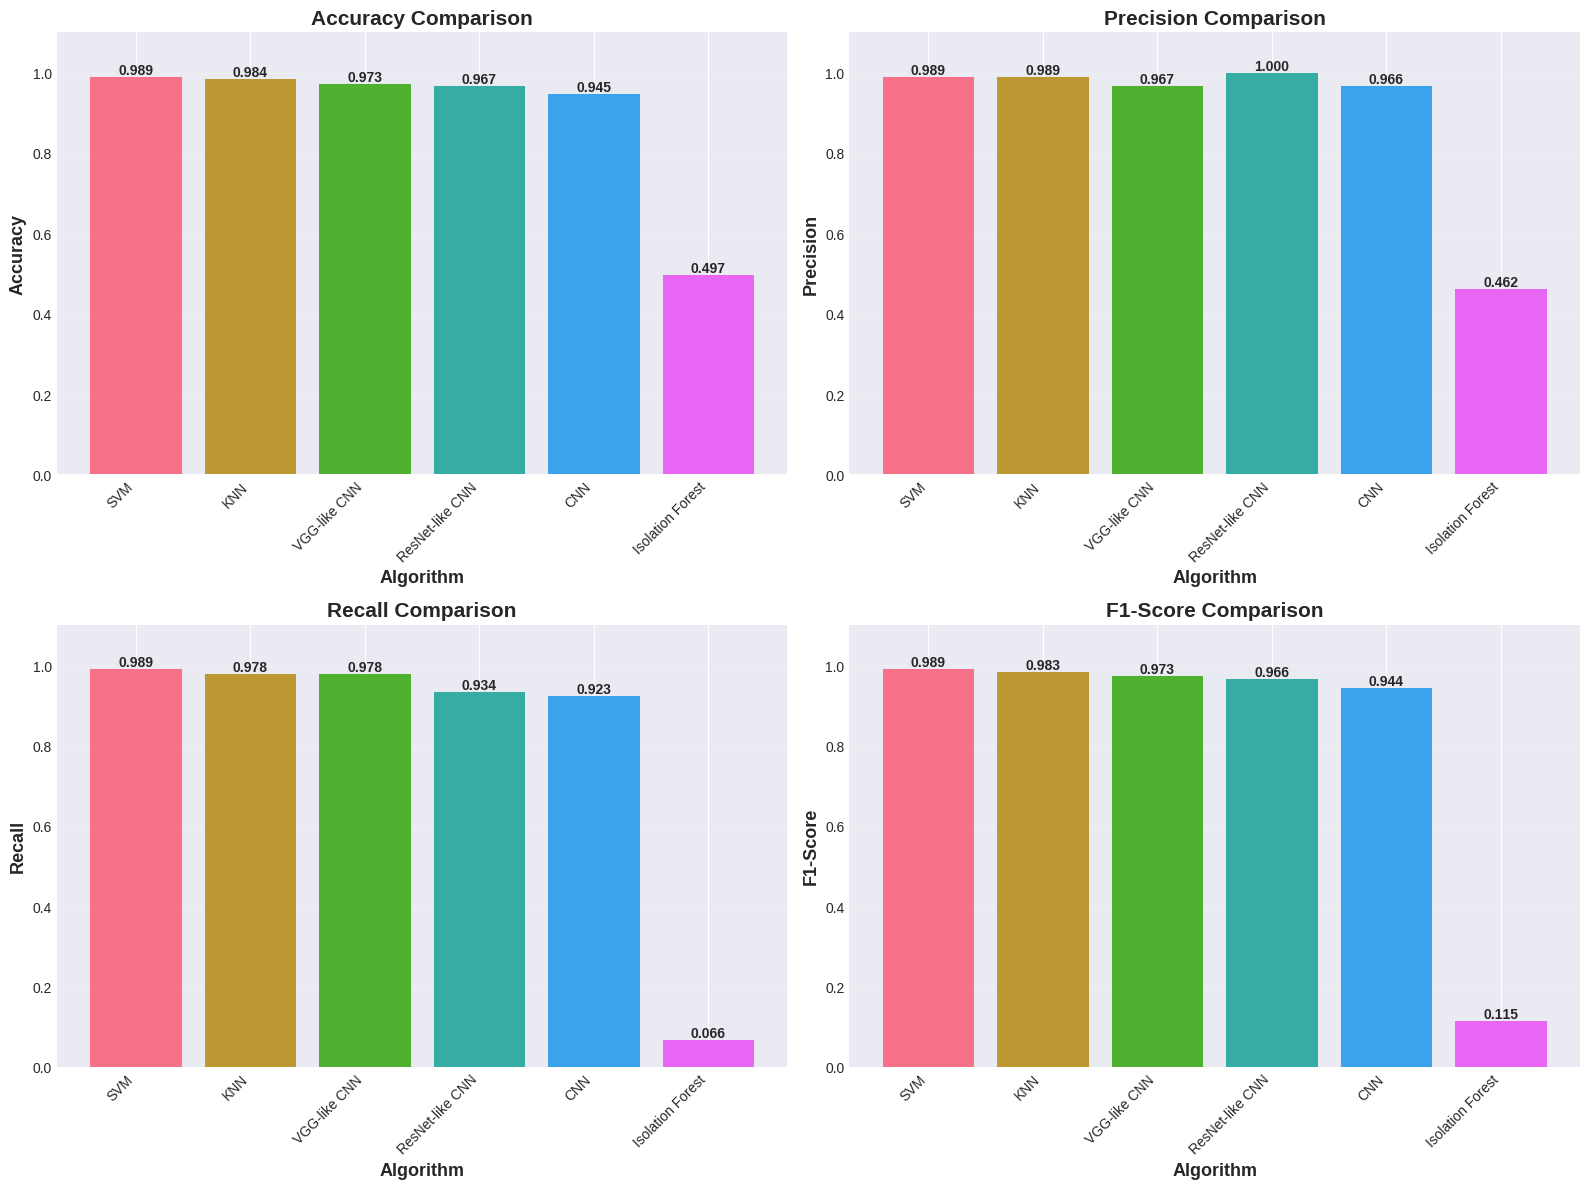

 Comparison plot saved to /content/drive/My Drive/TractorCare/outputs/model_comparison.png


In [ ]:
# Performance comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = sns.color_palette("husl", len(results_df))

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    # Create bar plot
    bars = ax.bar(results_df['Algorithm'], results_df[metric], color=colors)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Styling
    ax.set_ylabel(metric, fontsize=13, fontweight='bold')
    ax.set_xlabel('Algorithm', fontsize=13, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=15, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(config.output_dir / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Comparison plot saved to {config.output_dir / 'model_comparison.png'}")

# **Confusion Matrices**

Visualize confusion matrices for all models to understand classification performance.

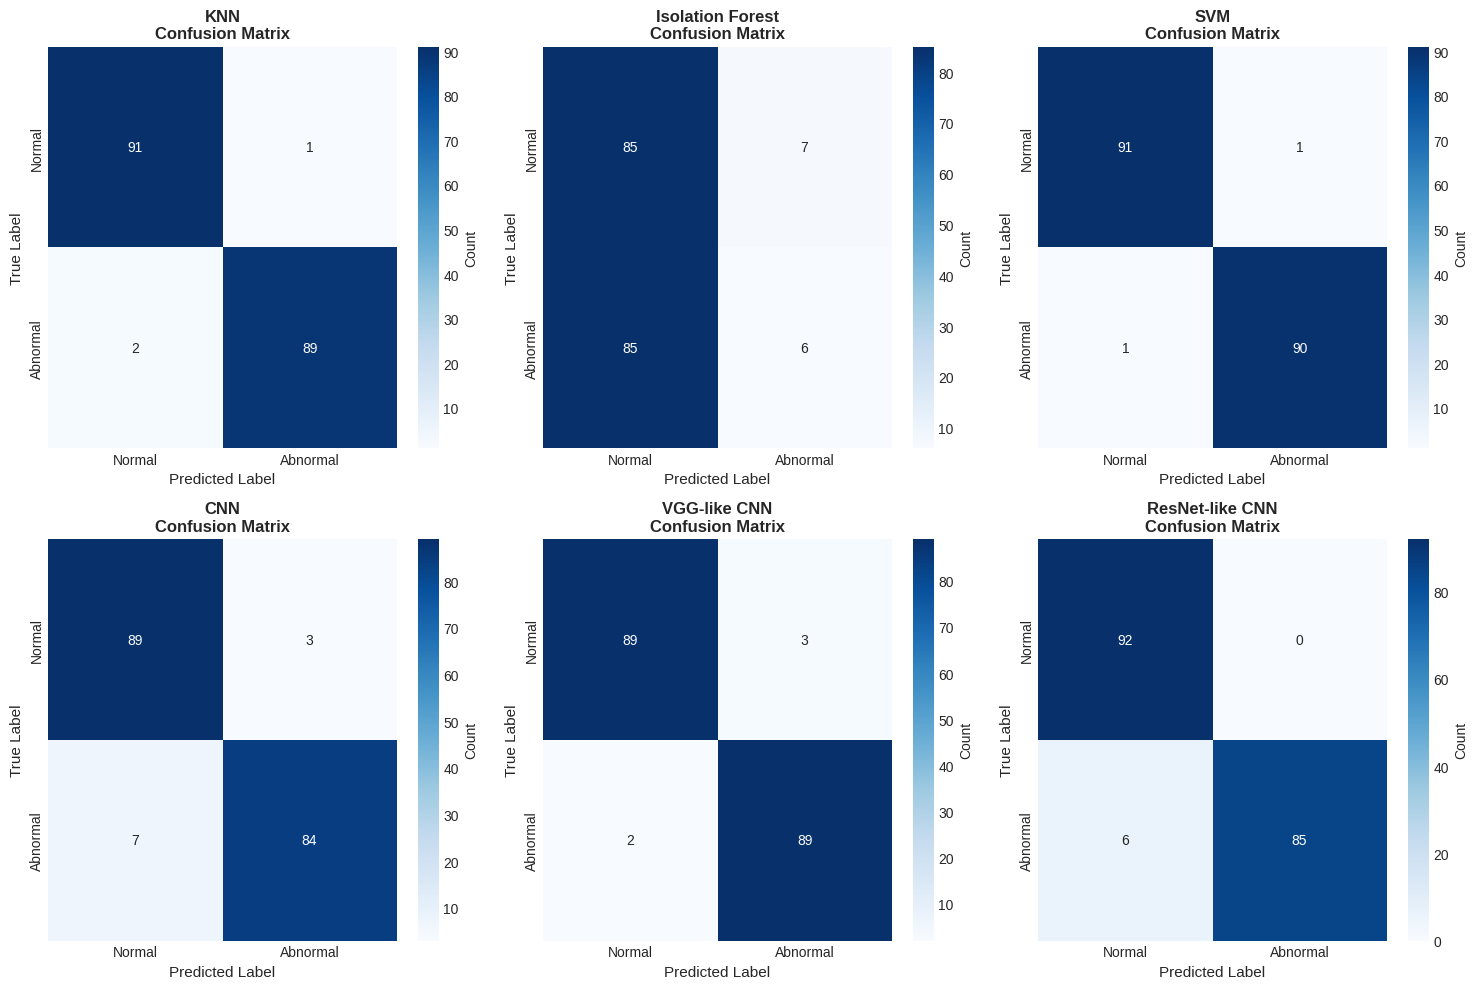

 Confusion matrices saved to /content/drive/My Drive/TractorCare/outputs/confusion_matrices.png


In [ ]:
# Create confusion matrices for all models
n_models = len(all_results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, (model_name, result) in enumerate(all_results.items()):
    cm = np.array(result['metrics']['confusion_matrix'])

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Normal', 'Abnormal'],
                yticklabels=['Normal', 'Abnormal'],
                cbar_kws={'label': 'Count'})

    axes[idx].set_title(f'{model_name}\nConfusion Matrix',
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

# Hide extra subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(config.output_dir / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Confusion matrices saved to {config.output_dir / 'confusion_matrices.png'}")

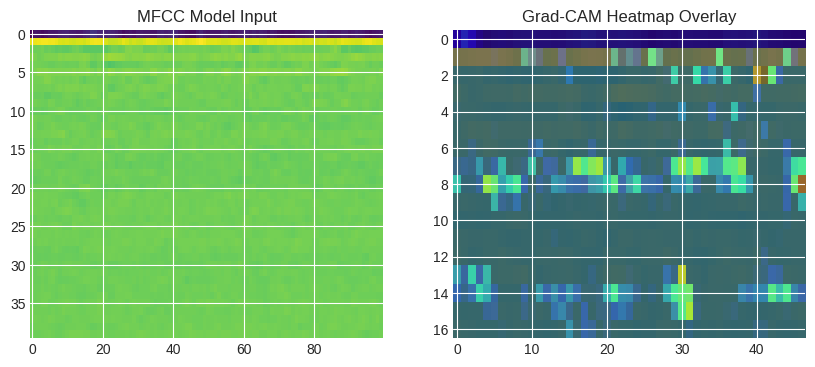

In [ ]:
# ---- Grad-CAM for CNNs (MFCC input) ----
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np # Import numpy

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Ensure the model is built by calling it with a dummy input
    if not model.built:
        # Create a dummy input tensor with the expected shape (batch_size=1)
        dummy_input = tf.random.normal((1,) + model.input_shape[1:])
        model(dummy_input) # Call the model to build it

    # Create a model that maps the input image to the activations of the last conv layer and the final predictions
    grad_model = tf.keras.models.Model(
        inputs=model.layers[0].input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.layers[-1].output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        # Ensure predictions is the output you want to differentiate with respect to
        # For binary classification with sigmoid, it's typically the output node itself
        loss = predictions[:, 0] # Assuming the output is a single value probability

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) # Use tf.maximum instead of np.maximum
    if tf.reduce_max(heatmap) != 0: # Use tf.reduce_max for tensor
        heatmap /= tf.reduce_max(heatmap) # Perform division on tensor
    return heatmap.numpy() # Convert to NumPy array at the end

# Use the Simple CNN model for demonstration
cnn_model = cnn_results['CNN']['model']
# Find the name of the last convolutional layer dynamically
last_conv = [l.name for l in cnn_model.layers if isinstance(l, tf.keras.layers.Conv2D)][-1]

idx = 0  # index of a test sample to visualize
img = X_test_cnn[idx:idx+1]  # shape (1, 40, 100, 1)


heatmap = make_gradcam_heatmap(img, cnn_model, last_conv)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('MFCC Model Input')
plt.imshow(img[0,:,:,0], aspect='auto', cmap='viridis')
plt.subplot(1,2,2)
plt.title('Grad-CAM Heatmap Overlay')
plt.imshow(img[0,:,:,0], aspect='auto', cmap='viridis')
plt.imshow(heatmap, cmap='jet', alpha=0.5, aspect='auto')
plt.show()

# **Training History (CNN Models)**

Plot training and validation loss/accuracy curves for deep learning models.

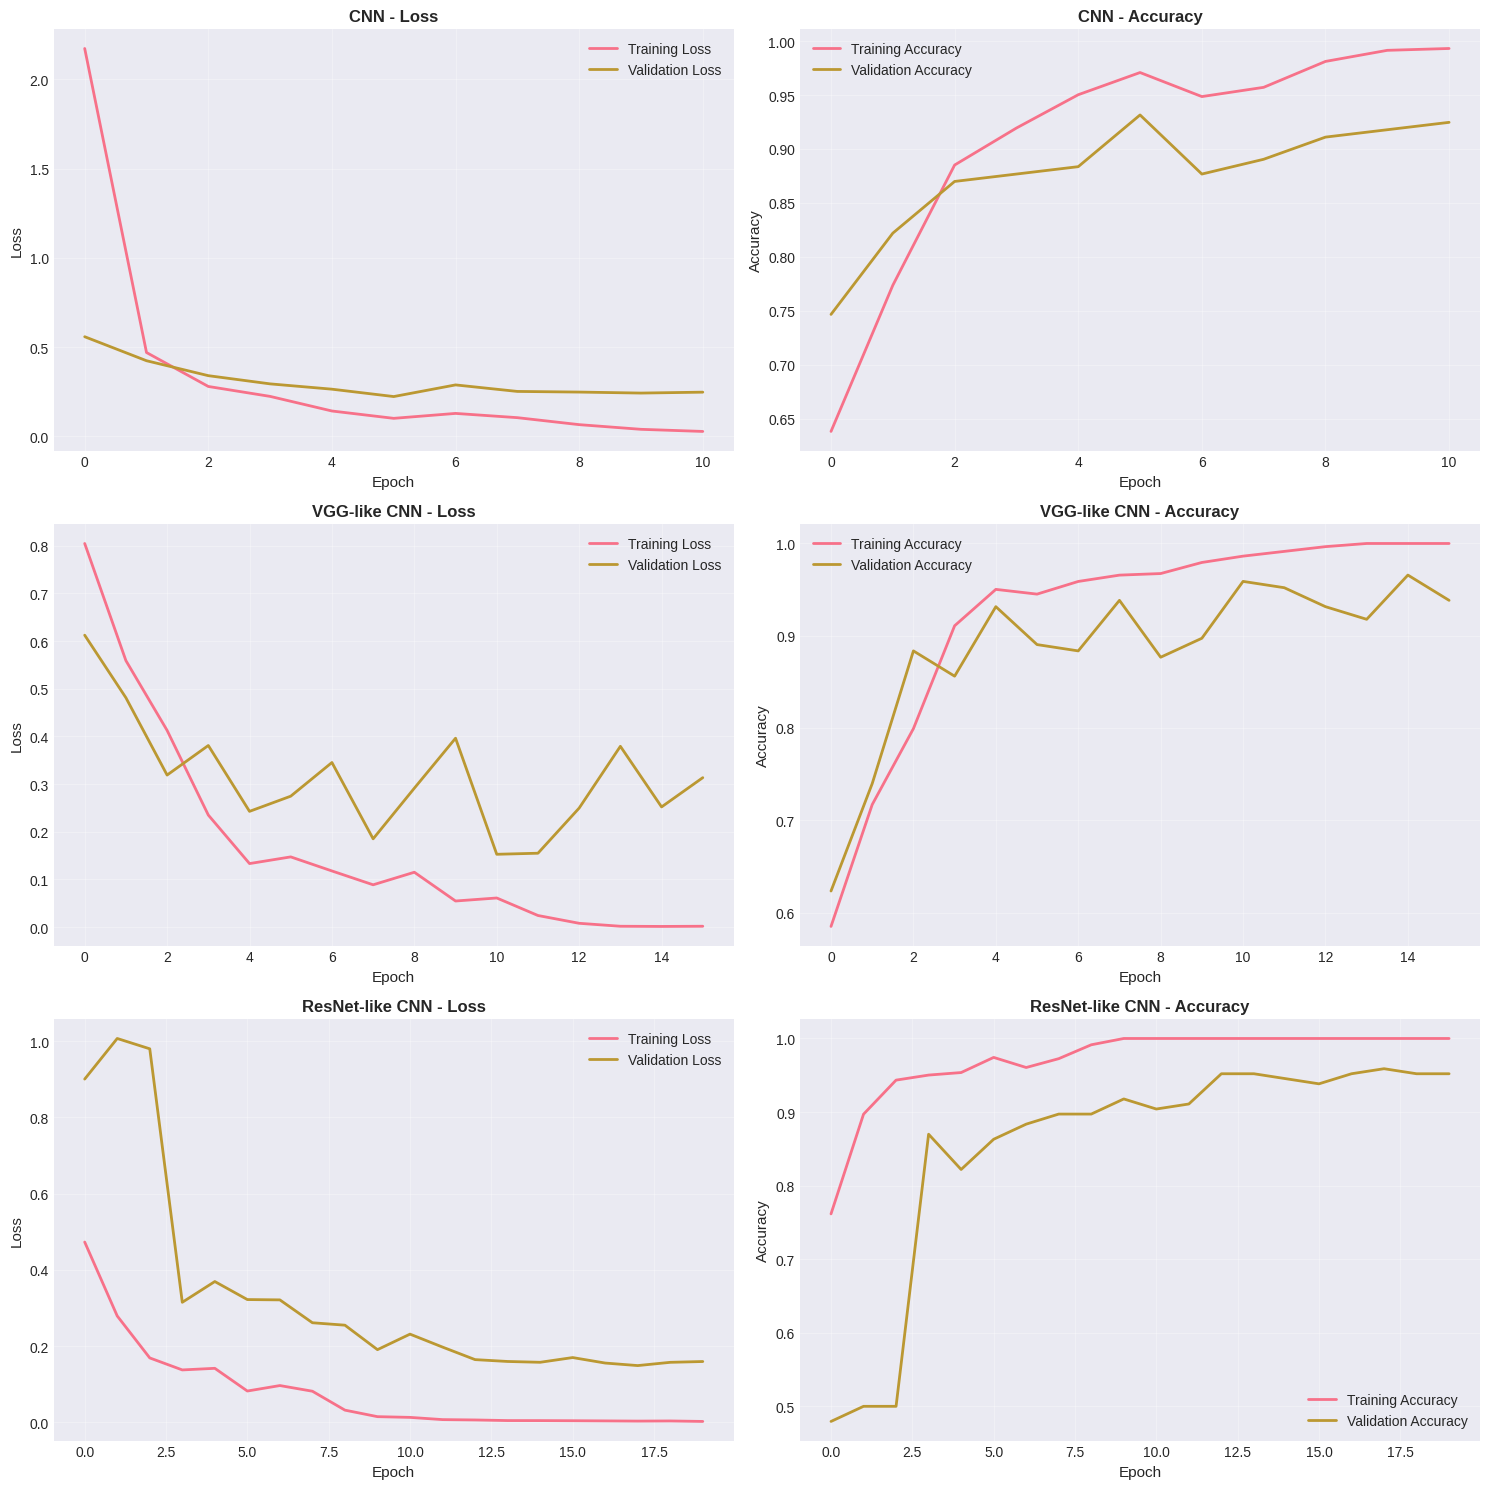

✓ Training history saved to /content/drive/My Drive/TractorCare/outputs/training_history.png


In [ ]:
# Plot training history for CNN models
cnn_models = [name for name in all_results.keys() if 'CNN' in name]

fig, axes = plt.subplots(len(cnn_models), 2, figsize=(15, 5 * len(cnn_models)))

if len(cnn_models) == 1:
    axes = axes.reshape(1, -1)

for idx, model_name in enumerate(cnn_models):
    history = all_results[model_name]['history']

    # Loss plot
    axes[idx, 0].plot(history['loss'], label='Training Loss', linewidth=2)
    axes[idx, 0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
    axes[idx, 0].set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Epoch', fontsize=11)
    axes[idx, 0].set_ylabel('Loss', fontsize=11)
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[idx, 1].plot(history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[idx, 1].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[idx, 1].set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
    axes[idx, 1].set_xlabel('Epoch', fontsize=11)
    axes[idx, 1].set_ylabel('Accuracy', fontsize=11)
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.output_dir / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training history saved to {config.output_dir / 'training_history.png'}")

# **Save Models**

Save all trained models and the scaler for future use.

In [ ]:
# ==============================================================
# SAVE ONLY RESNET-LIKE CNN (or Transfer Model) + SCALER
# ==============================================================

from pathlib import Path
import joblib
import json

# Create models directory
models_dir = config.output_dir / 'models'
models_dir.mkdir(exist_ok=True)
print(f"Saving models to {models_dir}/\n")

# Save scaler (needed for traditional ML if used later)
scaler_path = models_dir / 'scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f" Scaler saved: {scaler_path}")

# Save ONLY ResNet-like CNN (from MIMII training)
resnet_model = all_results['ResNet-like CNN']['model']
resnet_path = models_dir / 'resnet_like_cnn.h5'
resnet_model.save(resnet_path)
print(f" ResNet-like CNN saved: {resnet_path}")

# Save transfer model (if exists from tractor fine-tuning)
transfer_path = models_dir / 'tractor_resnet_transfer.h5'
if transfer_path.exists():
    print(f" Transfer model already exists: {transfer_path}")
else:
    print(f" Transfer model not found. Will be created later.")

# Save config
config.save_config()

print(f"\n{'='*60}")
print(" All essential models and config saved!")
print(f"{'='*60}")

Saving models to /content/drive/My Drive/TractorCare/outputs/models/



 Scaler saved: /content/drive/My Drive/TractorCare/outputs/models/scaler.pkl
 ResNet-like CNN saved: /content/drive/My Drive/TractorCare/outputs/models/resnet_like_cnn.h5
 Transfer model not found. Will be created later.
✓ Configuration saved to /content/drive/My Drive/TractorCare/outputs/config.json

 All essential models and config saved!


# **Model Loading and Prediction Interface**

Create a unified interface for loading models and making predictions on new audio files.

In [ ]:
# ==============================================================
# UPDATED: AudioAnomalyPredictor (Loads ONLY ResNet CNN)
# ==============================================================

from pathlib import Path
import numpy as np
import joblib
import json
import tensorflow as tf
from tensorflow import keras

# Re-define Config class if it's not globally available in this scope
# In a real script/package, this would be imported
class Config:
    """Central configuration for the project."""
    def __init__(self, environment='colab', config_dict=None):
        if config_dict:
            # Load from dictionary
            for key, value in config_dict.items():
                setattr(self, key, value)
            # Ensure required attributes exist, set defaults if necessary
            self.environment = config_dict.get('environment', environment)
            self.sample_rate = config_dict.get('sample_rate', 16000)
            self.duration = config_dict.get('duration', 10)
            self.n_mfcc = config_dict.get('n_mfcc', 40)
            self.max_len = config_dict.get('max_len', 100)
            self.apply_highpass = config_dict.get('apply_highpass', False) # Default
            self.test_size = config_dict.get('test_size', 0.2) # Default
            self.epochs = config_dict.get('epochs', 20) # Default
            self.batch_size = config_dict.get('batch_size', 32) # Default
            self.random_state = config_dict.get('random_state', 42) # Default
            self.machine_ids = config_dict.get('machine_ids', ["id_00", "id_02", "id_04", "id_06"]) # Default
            self.output_dir = Path(config_dict.get('output_dir', './outputs')) # Default
            self.base_path = Path(config_dict.get('base_path', './data/pump')) # Default
            self.validation_split = config_dict.get('validation_split', 0.2) # Default
            self.early_stopping_patience = config_dict.get('early_stopping_patience', 5) # Default
            self.knn_params = config_dict.get('knn_params', {'n_neighbors': 5, 'weights': 'distance'}) # Default
            self.svm_params = config_dict.get('svm_params', {'kernel': 'rbf', 'probability': True, 'C': 1.0}) # Default
            self.iso_forest_params = config_dict.get('iso_forest_params', {'contamination': 0.1, 'random_state': 42}) # Default


        else:
            # Initialize with defaults (like the original Config class)
            self.environment = environment
            self.setup_paths()
            self.setup_parameters()


    def setup_paths(self):
        """Configure paths based on environment."""
        if self.environment == 'colab':
            # Assuming drive is already mounted
            self.base_path = Path("/content/drive/My Drive/TractorCare/data/pump/")
            self.output_dir = Path("/content/drive/My Drive/TractorCare/outputs/")
        elif self.environment == 'local':
            self.base_path = Path("./data/pump/")
            self.output_dir = Path("./outputs/")
        else:  # production
            self.base_path = Path("/app/data/pump/")
            self.output_dir = Path("/app/outputs/")

        # Create output directory if it doesn't exist
        self.output_dir.mkdir(parents=True, exist_ok=True)

        self.machine_ids = ["id_00", "id_02", "id_04", "id_06"]

    def setup_parameters(self):
        """Set feature extraction and training parameters."""
        # Audio parameters
        self.sample_rate = 16000
        self.duration = 10

        # Feature extraction
        self.n_mfcc = 40
        self.max_len = 100
        self.apply_highpass = False

        # Training parameters
        self.test_size = 0.2
        self.validation_split = 0.2
        self.random_state = 42

        # Model training
        self.epochs = 20
        self.batch_size = 32
        self.early_stopping_patience = 5

        # Traditional ML models
        self.knn_params = {'n_neighbors': 5, 'weights': 'distance'}
        self.svm_params = {'kernel': 'rbf', 'probability': True, 'C': 1.0}
        self.iso_forest_params = {'contamination': 0.1, 'random_state': 42}


class AudioAnomalyPredictor:
    """Predict anomalies using only the ResNet-like CNN (or transfer model)."""

    def __init__(self, models_dir):
        self.models_dir = Path(models_dir)
        self.model = None
        self.config = None # Store the Config object here
        self.model_name = "ResNet-like CNN"

    def load_model(self, use_transfer=False):
        """
        Load either:
          - tractor_resnet_transfer.h5 (if exists → preferred)
          - resnet_like_cnn.h5 (fallback)
        """
        print("Loading ResNet CNN model...\n")

        # Try transfer model first
        transfer_path = self.models_dir / 'tractor_resnet_transfer.h5'
        fallback_path = self.models_dir / 'resnet_like_cnn.h5'

        if use_transfer and transfer_path.exists():
            model_path = transfer_path
            self.model_name = "Tractor Transfer ResNet"
        elif fallback_path.exists():
            model_path = fallback_path
            self.model_name = "ResNet-like CNN (MIMII)"
        else:
            raise FileNotFoundError("No ResNet model found. Train and save first.")

        # Load config
        config_path = self.models_dir.parent / 'config.json'
        if config_path.exists():
            with open(config_path, 'r') as f:
                config_dict = json.load(f)
                # Reconstruct Config object from dictionary
                self.config = Config(config_dict=config_dict)
            print(f" Config loaded from {config_path}")
        else:
            # If config.json is not found, try to use the global config object if available
            # Or initialize a default Config object
            try:
                # Access the global config object defined earlier in the notebook
                global config
                self.config = config
                print(" Using global config object.")
            except NameError:
                print(" Warning: config.json not found and global config object not available. Using default Config.")
                self.config = Config() # Initialize with default values


        # Load model
        self.model = keras.models.load_model(model_path)
        print(f" {self.model_name} loaded from {model_path}")

    def predict(self, audio_file):
        """
        Predict anomaly using loaded ResNet CNN.
        """
        if self.model is None:
            return {'error': 'Model not loaded. Call load_model() first.'}
        if self.config is None:
             return {'error': 'Configuration not loaded. Call load_model() first.'}

        # Use the loaded Config object
        mfcc = extract_mfcc_features(audio_file, self.config)

        # Check if feature extraction failed
        if mfcc is None:
            # Return a dictionary with an error key, as before
            return {
                'error': 'Failed to extract MFCC features',
                'file': Path(audio_file).name # Use Path().name here for consistency
            }


        # Reshape for CNN: (1, n_mfcc, time, 1)
        X = np.expand_dims(mfcc, axis=0)
        X = np.expand_dims(X, axis=-1)

        # Predict
        prob = self.model.predict(X, verbose=0)[0][0]
        prediction = 1 if prob > 0.5 else 0
        confidence = prob if prediction == 1 else (1 - prob)
        condition = "Abnormal" if prediction == 1 else "Normal"

        return {
            'condition': condition,
            'confidence': float(confidence),
            'prediction': int(prediction),
            'model': self.model_name,
            'file': Path(audio_file).name
        }

    def predict_batch(self, audio_files):
        """Predict multiple files."""
        results = []
        for audio_file in tqdm(audio_files, desc="Predicting batch"):
            result = self.predict(audio_file)
            results.append(result)
        return results

print(" AudioAnomalyPredictor (ResNet-only) defined")

 AudioAnomalyPredictor (ResNet-only) defined


# **Test Predictions**

Test the prediction interface with sample audio files.

In [ ]:
# ==============================================================
# TEST PREDICTIONS USING RESNET CNN ONLY
# ==============================================================

# Define models_dir using the config object
models_dir = config.output_dir / 'models'

# Initialize and load ResNet model
predictor = AudioAnomalyPredictor(models_dir)

# Prefer transfer model if exists
try:
    predictor.load_model(use_transfer=True)
except:
    print("Transfer model not found. Loading base ResNet...")
    predictor.load_model(use_transfer=False)

print(f"\n{'='*60}")
print("TESTING RESNET CNN PREDICTIONS")
print(f"{'='*60}\n")

# Get one normal and one abnormal sample
sample_normal = valid_files[np.where(y == 0)[0][0]]
sample_abnormal = valid_files[np.where(y == 1)[0][0]]

# Predict normal
result_normal = predictor.predict(sample_normal)
if 'error' in result_normal:
    print(f"Error predicting {result_normal['file']}: {result_normal['error']}")
else:
    print(f"File: {result_normal['file']}")
    print(f"Predicted: {result_normal['condition']}")
    print(f"Confidence: {result_normal['confidence']:.2%}")
    print(f"Model: {result_normal['model']}")
    print(f"(Ground truth: Normal)\n")

# Predict abnormal
result_abnormal = predictor.predict(sample_abnormal)
if 'error' in result_abnormal:
    print(f"Error predicting {result_abnormal['file']}: {result_abnormal['error']}")
else:
    print(f"File: {result_abnormal['file']}")
    print(f"Predicted: {result_abnormal['condition']}")
    print(f"Confidence: {result_abnormal['confidence']:.2%}")
    print(f"Model: {result_abnormal['model']}")
    print(f"(Ground truth: Abnormal)\n")

print(f"{'='*60}")
print("Prediction test complete!")

Loading ResNet CNN model...

 Config loaded from /content/drive/My Drive/TractorCare/outputs/config.json


 ResNet-like CNN (MIMII) loaded from /content/drive/My Drive/TractorCare/outputs/models/resnet_like_cnn.h5

TESTING RESNET CNN PREDICTIONS



File: 00000864.wav
Predicted: Normal
Confidence: 99.92%
Model: ResNet-like CNN (MIMII)
(Ground truth: Normal)

File: 00000001.wav
Predicted: Abnormal
Confidence: 99.98%
Model: ResNet-like CNN (MIMII)
(Ground truth: Abnormal)

Prediction test complete!


# **PART 2: Transfer Learning & Edge Deployment**

**Objective:**  
Apply **best model (ResNet-like CNN)** to real **tractor sounds** and simulate **edge AI deployment**.

**Steps:**  
1. Import & convert tractor audio  
2. Transfer learning from MIMII → Tractor  
3. Per-tractor baseline (Reality AI style)  
4. Offline-first detection with adaptive learning  
5. Final field test simulation (Rwanda)

**Why Transfer Learning?**  
- Limited labeled tractor data  
- ResNet already learned industrial sound patterns  
- Fine-tune with low LR → fast, effective

In [ ]:
# ==============================================================
# 1. CONVERT ALL TRACTOR AUDIO TO 16 kHz MONO WAV
# ==============================================================

!pip install -q pydub tqdm

import os
from pathlib import Path
from tqdm import tqdm
from pydub import AudioSegment
import random
import time
import json
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --------------------------------------------------------------
# Paths
# --------------------------------------------------------------
tractor_base = config.base_path.parent / "tractor"
normal_dir   = tractor_base / "normal"
abnormal_dir = tractor_base / "abnormal"

for d in (normal_dir, abnormal_dir):
    d.mkdir(parents=True, exist_ok=True)

# --------------------------------------------------------------
# Helper: Convert any format → 16 kHz mono WAV
# --------------------------------------------------------------
def to_wav(src_path: Path, dst_path: Path, sr: int = 16000):
    try:
        audio = AudioSegment.from_file(str(src_path))
        audio = audio.set_channels(1).set_frame_rate(sr)
        audio.export(str(dst_path), format="wav")
        return True
    except Exception as e:
        print(f"Failed {src_path.name}: {e}")
        return False

# --------------------------------------------------------------
# Convert folder
# --------------------------------------------------------------
def convert_folder(folder: Path):
    wav_paths = []
    extensions = ("*.wav", "*.mp3", "*.m4a", "*.flac", "*.ogg", "*.aac")
    files = []
    for ext in extensions:
        files.extend(folder.glob(ext))

    print(f"\nProcessing {len(files)} files in {folder.name}...")
    for src in tqdm(files, desc=folder.name):
        dst = src.with_suffix(".wav")
        if dst.exists() and dst.stat().st_size > 0:
            wav_paths.append(str(dst))
            continue
        if to_wav(src, dst, sr=config.sample_rate):
            wav_paths.append(str(dst))
    return wav_paths

# Run conversion
tractor_normal_files   = convert_folder(normal_dir)
tractor_abnormal_files = convert_folder(abnormal_dir)

print("\n=== FINAL LISTS (WAV only) ===")
print(f"Normal   : {len(tractor_normal_files)} files")
print(f"Abnormal : {len(tractor_abnormal_files)} files")
print(f"Total    : {len(tractor_normal_files) + len(tractor_abnormal_files)} WAV files")


Processing 9 files in normal...


normal: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]



Processing 6 files in abnormal...


abnormal: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


=== FINAL LISTS (WAV only) ===
Normal   : 9 files
Abnormal : 6 files
Total    : 15 WAV files


In [ ]:
# Define the corrected Config class again to ensure it's used
class Config:
    """Central configuration for the project."""

    def __init__(self, environment='colab', config_dict=None):
        if config_dict:
            # Load from dictionary
            for key, value in config_dict.items():
                setattr(self, key, value)
            # Ensure required attributes exist, set defaults if necessary
            self.environment = config_dict.get('environment', environment)
            self.sample_rate = config_dict.get('sample_rate', 16000)
            self.duration = config_dict.get('duration', 10)
            self.n_mfcc = config_dict.get('n_mfcc', 40)
            self.max_len = config_dict.get('max_len', 100)
            self.apply_highpass = config_dict.get('apply_highpass', False) # Default
            self.test_size = config_dict.get('test_size', 0.2) # Default
            self.epochs = config_dict.get('epochs', 20) # Default
            self.batch_size = config_dict.get('batch_size', 32) # Default
            self.random_state = config_dict.get('random_state', 42) # Default
            self.machine_ids = config_dict.get('machine_ids', ["id_00", "id_02", "id_04", "id_06"]) # Default
            self.output_dir = Path(config_dict.get('output_dir', './outputs')) # Default
            self.base_path = Path(config_dict.get('base_path', './data/pump')) # Default
            self.validation_split = config_dict.get('validation_split', 0.2) # Default
            self.early_stopping_patience = config_dict.get('early_stopping_patience', 5) # Default
            self.knn_params = config_dict.get('knn_params', {'n_neighbors': 5, 'weights': 'distance'}) # Default
            self.svm_params = config_dict.get('svm_params', {'kernel': 'rbf', 'probability': True, 'C': 1.0}) # Default
            self.iso_forest_params = config_dict.get('iso_forest_params', {'contamination': 0.1, 'random_state': 42}) # Default

        else:
            # Initialize with defaults (like the original Config class)
            self.environment = environment
            self.setup_paths()
            self.setup_parameters()

    def setup_paths(self):
        """Configure paths based on environment."""
        if self.environment == 'colab':
            from google.colab import drive
            drive.mount('/content/drive')
            self.base_path = Path("/content/drive/My Drive/TractorCare/data/pump/")
            self.output_dir = Path("/content/drive/My Drive/TractorCare/outputs/")
        elif self.environment == 'local':
            self.base_path = Path("./data/pump/")
            self.output_dir = Path("./outputs/")
        else:  # production
            self.base_path = Path("/app/data/pump/")
            self.output_dir = Path("/app/outputs/")

        # Create output directory if it doesn't exist
        self.output_dir.mkdir(parents=True, exist_ok=True)

        self.machine_ids = ["id_00", "id_02", "id_04", "id_06"]

    def setup_parameters(self):
        """Set feature extraction and training parameters."""
        # Audio parameters
        self.sample_rate = 16000
        self.duration = 10

        # Feature extraction
        self.n_mfcc = 40
        self.max_len = 100
        self.apply_highpass = False

        # Training parameters
        self.test_size = 0.2
        self.validation_split = 0.2
        self.random_state = 42

        # Model training
        self.epochs = 20
        self.batch_size = 32
        self.early_stopping_patience = 5

        # Traditional ML models
        self.knn_params = {'n_neighbors': 5, 'weights': 'distance'}
        self.svm_params = {'kernel': 'rbf', 'probability': True, 'C': 1.0}
        self.iso_forest_params = {'contamination': 0.1, 'random_state': 42}

    def get_file_paths(self):
        """Load all audio file paths from dataset."""
        normal_files = []
        abnormal_files = []

        for mid in self.machine_ids:
            normal_dir = self.base_path / mid / "normal"
            abnormal_dir = self.base_path / mid / "abnormal"

            if normal_dir.exists():
                normal_files.extend([str(f) for f in normal_dir.glob("*.wav")])
            else:
                print(f"⚠ Warning: {normal_dir} not found")

            if abnormal_dir.exists():
                abnormal_files.extend([str(f) for f in abnormal_dir.glob("*.wav")])
            else:
                print(f"⚠ Warning: {abnormal_dir} not found")

        return normal_files, abnormal_files

    def save_config(self):
        """Save configuration to JSON file."""
        config_dict = {
            'environment': self.environment,
            'sample_rate': self.sample_rate,
            'duration': self.duration,
            'n_mfcc': self.n_mfcc,
            'max_len': self.max_len,
            'test_size': self.test_size,
            'epochs': self.epochs,
            'batch_size': self.batch_size
        }

        config_path = self.output_dir / 'config.json'
        with open(config_path, 'w') as f:
            json.dump(config_dict, f, indent=4)

        print(f"✓ Configuration saved to {config_path}")

In [ ]:
# ==============================================================
# 2. BALANCE, EXTRACT FEATURES (MFCC)
# ==============================================================

# Balance
normal_sample_size = len(tractor_abnormal_files)
tractor_normal_balanced = resample(
    tractor_normal_files,
    n_samples=normal_sample_size,
    random_state=config.random_state
)

# Combine
all_files = tractor_normal_balanced + tractor_abnormal_files
all_labels = [0] * len(tractor_normal_balanced) + [1] * len(tractor_abnormal_files)

# Extract MFCCs
X_mfcc, X_stats, y, valid_files = extract_features_batch(
    all_files,
    all_labels,
    config,
    desc="Extracting tractor features"
)

print(f"MFCC shape: {X_mfcc.shape}")

Extracting tractor features: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


 Successfully processed: 12 files
MFCC shape: (12, 40, 100)


In [ ]:
# ==============================================================
# 3. TRANSFER LEARNING: MIMII ResNet → Tractor
# ==============================================================

# Load pre-trained MIMII ResNet
pretrained_path = config.output_dir / 'models' / 'resnet_like_cnn.h5'
if not pretrained_path.exists():
    raise FileNotFoundError(f"Pretrained model not found: {pretrained_path}")

pretrained_model = keras.models.load_model(pretrained_path)
print("Pretrained MIMII ResNet loaded")

# Freeze all but last 3 layers
for layer in pretrained_model.layers[:-3]:
    layer.trainable = False

# Build transfer model
transfer_model = Sequential([
    pretrained_model,
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

transfer_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(
    X_mfcc, y, test_size=0.2, random_state=42, stratify=y
)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Train
callbacks = [EarlyStopping(patience=5, restore_best_weights=True)]
history = transfer_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
loss, acc = transfer_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTransfer Learning Accuracy on Tractor Data: {acc:.2%}")

# Save transfer model
transfer_save_path = config.output_dir / 'models' / 'tractor_resnet_transfer.h5'
transfer_model.save(transfer_save_path)
print(f"Transfer model saved: {transfer_save_path}")

Pretrained MIMII ResNet loaded
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.4286 - loss: 0.7196 - val_accuracy: 0.5000 - val_loss: 0.7072
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: 0.7161 - val_accuracy: 0.5000 - val_loss: 0.7071
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.4286 - loss: 0.7333 - val_accuracy: 0.5000 - val_loss: 0.7070
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.4286 - loss: 0.7187 - val_accuracy: 0.5000 - val_loss: 0.7068
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.4286 - loss: 0.7154 - val_accuracy: 0.5000 - val_loss: 0.7067
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.4286 - loss: 0.7148 - val_accuracy: 0.5000 - val_loss: 0.7066
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.4286 - loss: 0.7168 - val_accuracy: 0.5000 - val_loss: 0.7065
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.4286 - loss: 0.7238 - val_a


Transfer Learning Accuracy on Tractor Data: 66.67%
Transfer model saved: /content/drive/My Drive/TractorCare/outputs/models/tractor_resnet_transfer.h5


In [ ]:
# ==============================================================
# 4. REALITY AI SIMULATION: Per-Tractor + Online/Offline
# ==============================================================

class RealityAISimulator:
    def __init__(self, tractor_id, models_dir, config):
        self.tractor_id = tractor_id
        self.models_dir = Path(models_dir)
        self.baseline_dir = self.models_dir.parent / f"baselines/{tractor_id}"
        self.baseline_dir.mkdir(parents=True, exist_ok=True)
        self.config = config
        self.model = None
        self.normal_buffer = []
        self.connectivity = True

    def set_connectivity(self):
        self.connectivity = random.random() > 0.7  # 70% offline
        return "ONLINE" if self.connectivity else "OFFLINE"

    def build_baseline(self, normal_wav_files):
        print(f"\nBuilding baseline for {self.tractor_id}...")
        mfccs = []
        for f in normal_wav_files[:15]:
            mfcc = extract_mfcc_features(f, self.config)
            if mfcc is not None:
                mfccs.append(np.expand_dims(mfcc, -1))
        if not mfccs:
            print("No valid normal files!")
            return
        X = np.array(mfccs)
        y = np.zeros(len(X))

        # Clone transfer model
        base = keras.models.load_model(self.models_dir / 'tractor_resnet_transfer.h5')
        self.model = keras.models.clone_model(base)
        self.model.set_weights(base.get_weights())
        self.model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy')
        self.model.fit(X, y, epochs=2, verbose=0)
        self.save_baseline()
        print(f"Baseline built for {self.tractor_id}")

    def detect(self, audio_file):
        if self.model is None:
            self.load_baseline()
        mfcc = extract_mfcc_features(audio_file, self.config)
        if mfcc is None:
            return {"error": "Feature extraction failed"}
        X = np.expand_dims(np.expand_dims(mfcc, 0), -1)
        prob = self.model.predict(X, verbose=0)[0][0]
        anomaly = prob > 0.5
        score = prob if anomaly else (1 - prob)

        # Adaptive learning
        if not anomaly and len(self.normal_buffer) < 50:
            self.normal_buffer.append(X.squeeze())
            if len(self.normal_buffer) >= 10:
                self.retrain_buffer()

        # Online sync
        status = self.set_connectivity()
        if anomaly and self.connectivity:
            self.sync_online(audio_file, score)

        return {
            "tractor": self.tractor_id,
            "file": Path(audio_file).name,
            "status": status,
            "condition": "ABNORMAL" if anomaly else "NORMAL",
            "confidence": f"{score:.1%}",
            "action": "SYNCED" if (anomaly and self.connectivity) else "LOCAL ONLY"
        }

    def retrain_buffer(self):
        if len(self.normal_buffer) < 5:
            return
        X_buf = np.array(self.normal_buffer[-20:])
        y_buf = np.zeros(len(X_buf))
        self.model.fit(X_buf, y_buf, epochs=1, verbose=0)
        self.save_baseline()
        self.normal_buffer = self.normal_buffer[-10:]  # Keep last 10
        print(f"Baseline updated for {self.tractor_id}")

    def sync_online(self, file, score):
        log = {
            "tractor": self.tractor_id,
            "file": Path(file).name,
            "score": score,
            "time": time.strftime("%Y-%m-%d %H:%M:%S")
        }
        sync_file = self.baseline_dir / "sync_log.json"
        logs = []
        if sync_file.exists():
            try:
                with open(sync_file) as f:
                    logs = json.load(f)
            except:
                logs = []
        logs.append(log)
        with open(sync_file, 'w') as f:
            json.dump(logs, f, indent=2)
        print(f"Synced: {self.tractor_id} → {Path(file).name}")

    def save_baseline(self):
        if self.model:
            self.model.save(self.baseline_dir / "model.h5")

    def load_baseline(self):
        path = self.baseline_dir / "model.h5"
        if path.exists():
            self.model = keras.models.load_model(path)
        else:
            print(f"No baseline for {self.tractor_id} — run build_baseline()")

In [ ]:
# ==============================================================
# 5. DEMO: 3 Tractors in Rwanda
# ==============================================================

tractors = {
    "MF240_Kayonza": RealityAISimulator("MF240_Kayonza", config.output_dir / 'models', config),
    "JD510_Rubavu":   RealityAISimulator("JD510_Rubavu", config.output_dir / 'models', config),
    "Kubota_Musanze": RealityAISimulator("Kubota_Musanze", config.output_dir / 'models', config)
}

# Build baselines
for sim in tractors.values():
    sim.build_baseline(tractor_normal_files)

# Field test
print("\n" + "="*80)
print("REALITY AI SIMULATION: FIELD TEST (Rwanda Farm Area")
print("="*80)

test_files = (
    random.sample(tractor_normal_files, min(3, len(tractor_normal_files))) +
    random.sample(tractor_abnormal_files, min(3, len(tractor_abnormal_files)))
)

for f in test_files:
    tractor_name = random.choice(list(tractors.keys()))
    result = tractors[tractor_name].detect(f)
    print(f"{result['tractor']} → {result['condition']} ({result['confidence']}) | {result['status']} | {result['action']}")


Building baseline for MF240_Kayonza...


Baseline built for MF240_Kayonza

Building baseline for JD510_Rubavu...


Baseline built for JD510_Rubavu

Building baseline for Kubota_Musanze...


Baseline built for Kubota_Musanze

REALITY AI SIMULATION: FIELD TEST (Rwanda Farm Area
Kubota_Musanze → NORMAL (57.7%) | OFFLINE | LOCAL ONLY
Kubota_Musanze → NORMAL (57.7%) | ONLINE | LOCAL ONLY
Kubota_Musanze → NORMAL (57.7%) | OFFLINE | LOCAL ONLY
JD510_Rubavu → NORMAL (55.0%) | OFFLINE | LOCAL ONLY
Kubota_Musanze → NORMAL (57.7%) | OFFLINE | LOCAL ONLY
Kubota_Musanze → NORMAL (57.7%) | OFFLINE | LOCAL ONLY
